# DVA263 project

# Libraries

Declaring all libraries in use

In [1]:
import autoencoder as ae

import cnn as cnn
import preprocessing as pre
import visualization as viz
import metrics
import numpy as np

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

# Load Dataset

In [2]:
def load(image_size):
    train_path = "../dataset/Project/train/"
    test_path = "../dataset/Project/test/"
    
    X_train, y_train = pre.get_dataset(train_path, image_size)
    X_test, y_test = pre.get_dataset(test_path, image_size)
    
    return X_train, y_train, X_test, y_test

# Prepare Data

In [3]:
def prep_ae(X_train, y_train):
    return ae.preprocess_images(X_train, y_train)

def prep_cnn(X_train, y_train, X_test):
    """Add noise images to train and test set and normalize"""
    # Apply noise augmentation on train data
    g_noisy_train = pre.add_gaussian_noise(X_train)
    snp_noisy_train = pre.add_salt_and_pepper_noise(X_train)

    # Stack the original and noisy images together
    X_train_combined = np.concatenate((X_train, g_noisy_train, snp_noisy_train), axis=0)
    y_train_combined = np.concatenate((y_train, y_train, y_train), axis=0)  # Duplicate labels accordingly

    # Normalize datasets
    X_train_norm = pre.normalize_images(X_train_combined)
    X_test_norm = pre.normalize_images(X_test)

    return X_train_norm, y_train_combined, X_test_norm

# Build and Compile Models

In [4]:
def build_ae(image_size):
    model = ae.build_and_compile(image_size)
    return model
def build_cnn():
    model = cnn.build_cnn_model()
    return model

#  Train Models

In [5]:
def train_ae(model, ae_train):
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_delta=0.0005)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.0002, restore_best_weights=True)
    callbacks = [reduce_lr, early_stop]

    history = ae.fit_model(model, ae_train, epochs=30, batch_size=32, callbacks=callbacks)
    return history

def train_cnn(model,cnn_train, cnn_test):
    history = cnn.train_model(model, cnn_train, cnn_test)
    return history

# Anomaly detection procedure

In [6]:
def calculate_mse_list(input_images, predicted_images):
    values = []
    count = len(input_images)
    
    for i in range(count):
        temp_mse = metrics.mse(input_images[i], predicted_images[i])
        values.append(temp_mse)
        
    return values
        
def get_true_anomalies(labels):
    labels = np.argmax(labels, axis=1)
    y_true = []
    count = len(labels)
    
    for i in range(count):
        if labels[i] == 3:
            y_true.append(0)
        else: 
            y_true.append(1)
    return y_true

def detect_anomalies(mse_list, threshold):
    y_pred = []
    count = len(mse_list)
    
    for i in range(count):
        if mse_list[i] < threshold:
            y_pred.append(0)
        else:
            y_pred.append(1)
            
    return y_pred

# Plotting Training and Validation Figures

In [7]:
def visualize_training_history(ae_history, cnn_history):
    viz.plot_metrics(ae_history, "Autoencoder", accuracy=False)
    viz.plot_metrics(cnn_history, "CNN", accuracy=True)

# Putting everything together

Main section putting each part together, doing anomaly detection and running the classification task

## Import and preprocess data

### Load images

In [8]:
image_size = (152, 152)

X_train, y_train, X_test, y_test = load(image_size)

ae_X_train, ae_y_train = prep_ae(X_train, y_train)
X_test = pre.normalize_images(X_test)

Found 259 files belonging to 4 classes.
Found 33 files belonging to 4 classes.


### Prepare autoencoder training set and threshold set

In [9]:
normal_train, normal_test, anomaly_test = ae.get_training_and_threshold_set(ae_X_train, ae_y_train)

## Build and Train autoencoder

In [10]:
#ae_model = build_ae(image_size)
#ae_model.summary()

In [11]:
#ae_history = train_ae(ae_model, normal_train)
ae_model = load_model("./model.keras")

## Predict on normal and anomalous data to calculate threshold for anomaly detection procedure

In [12]:
normal_predictions = ae_model.predict(normal_test)
anomaly_predictions = ae_model.predict(anomaly_test)

print(normal_test.shape)
normal_mse = calculate_mse_list(normal_test, normal_predictions)
anomaly_mse = calculate_mse_list(anomaly_test, anomaly_predictions)

anomaly_threshold = (max(normal_mse) + min(anomaly_mse)) / 2

print(anomaly_threshold)

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step
(502, 152, 152, 3)
0.0014965984


## Train CNN model

In [13]:
# Load dataset
X_train, y_train, X_test, y_test = load((152, 152))

# Preprocess dataset (add noise + normalize)
X_train, y_train, X_test = prep_cnn(X_train, y_train, X_test)

print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Build and train the CNN model
CNN_model = build_cnn()
CNN_history = train_cnn(CNN_model, X_train, y_train)

# Predict on test set

Found 259 files belonging to 4 classes.
Found 33 files belonging to 4 classes.
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(777, 152, 152, 3) (777, 4)
(33, 152, 152, 3) (33, 4)
Epoch 1/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6937 - loss: 0.9225 - val_accuracy: 0.8013 - val_loss: 0.7226 - learning_rate: 0.0010
Epoch 2/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8307 - loss: 0.6532 - val_accuracy: 0.8013 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 3/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8094 - loss: 0.6982 - val_accuracy: 0.8013 - val_loss: 0.7546 - learning_rate: 0.0010
Epoch 4/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7995 - loss: 0.7269 - val_accuracy: 0.8013 - val_loss: 0.7595 - learning_rate: 0.0010
Epoch 5/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8076 - loss: 0.6950 - val_accuracy: 0.8013 - val_loss: 0.7160 - learning_rate: 0.0010
Epoch 6/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0

# Run the machine learning pipeline

In [14]:
y_anomaly_true = get_true_anomalies(y_test)
image_predictions = ae_model.predict(X_test)

mse_list = calculate_mse_list(X_test, image_predictions)
y_anomaly_pred = detect_anomalies(mse_list, anomaly_threshold)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [15]:
predictions = CNN_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


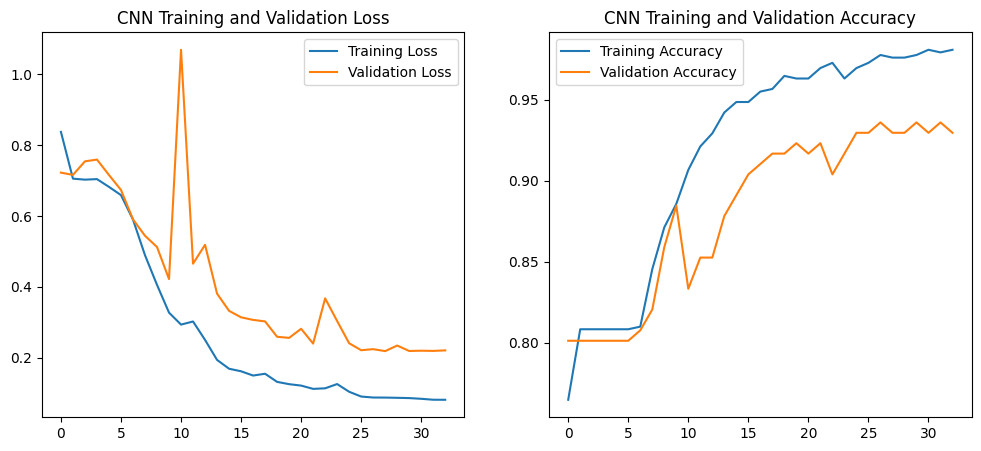

In [23]:
viz.plot_metrics(CNN_history, "CNN", accuracy=True)

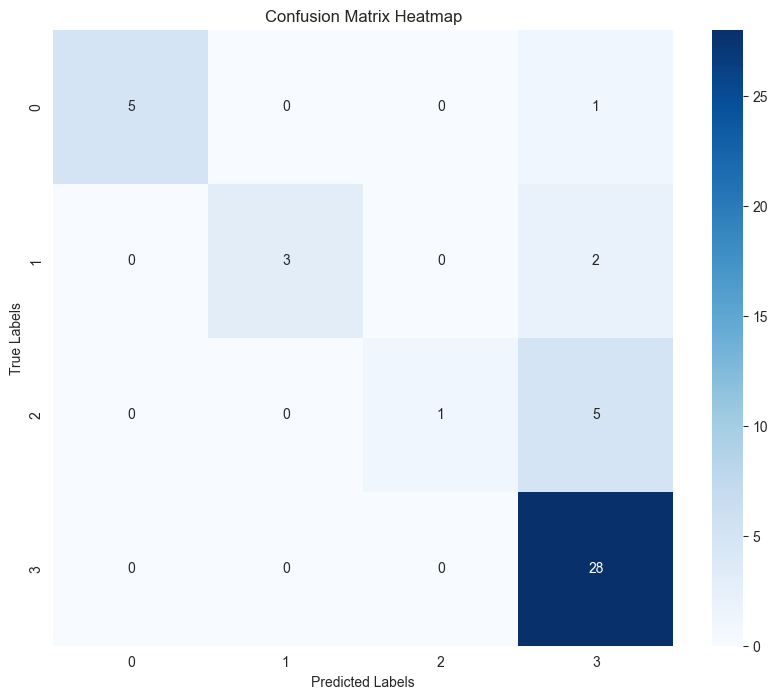

In [24]:
viz.plot_heatmap(y_test, predictions)